## 다중분류

데이터 출처 : https://www.kaggle.com/datasets/yasserh/wine-quality-dataset          
데이터 설명 : 와인 퀄리티 데이터셋

In [28]:
import pandas as pd

In [29]:
wine=pd.read_csv(r"C:\Users\SAMSUNG\Desktop\공부파일들\카글\WineQT.csv")
wine.drop("Id",axis=1,inplace=True)
target="quality"
feature=wine.columns.difference([target])

In [30]:
# 아래의 퀄리티를 예측하는 모델을 만들어보자
wine[target].value_counts()

quality
5    483
6    462
7    143
4     33
8     16
3      6
Name: count, dtype: int64

### step 1. 모델 선택

|모델||설명|분류기 개수|
|--|--|--|--|
|OvR/OvA|One versus Rest|특정 하나만 분류하는 모델의 만들어 결정점수가 가장 높은 값을 선택|N개(target 개수)|
|OvO|One versus One|둘 중 하나의 값만들 선택하는 binary classification 들의 조합|$\binom{n}{2}$

이진분류기로 다중분류 모델을 만들어보자

In [31]:
import sklearn.multiclass as skmul
import numpy as np
np.random.seed(10)

#### OvO 모델
* 사이킷런은 이진분류기로 다중분류 학습시 기본적으로 OvO 모델을 가정한다

In [32]:
import sklearn.svm as sksvm #svm 모델을 이용해보자
svc=sksvm.SVC(random_state=10) #파라미터는 그대로 

In [33]:
# 데이터 분류
import sklearn.model_selection as skmod
train,test=skmod.train_test_split(wine,random_state=10,stratify=wine[target],train_size=0.7)

-----

In [34]:
print(test[target][:1])

775    5
Name: quality, dtype: int64


------

In [35]:
svc.fit(X=train[feature],y=train[target])

SVC(random_state=10)

In [36]:
# 클래스 확인
svc.classes_

array([3, 4, 5, 6, 7, 8], dtype=int64)

In [37]:
svc.predict(X=test[feature][:1])

array([6], dtype=int64)

In [38]:
score=svc.decision_function(X=test[feature][:1])
print(score)
idx=score.argmax()
print(svc.classes_[idx]) # 이런 방식으로 선택

[[-0.27765236  1.83180822  4.25502015  5.27578461  3.16120585  0.75041452]]
6


#### OvR 모델

In [39]:
ovr_svc=skmul.OneVsRestClassifier(estimator=sksvm.SVC(random_state=10),n_jobs=3)

In [40]:
ovr_svc.fit(X=train[feature],y=train[target])

OneVsRestClassifier(estimator=SVC(random_state=10), n_jobs=3)

In [41]:
ovr_svc.predict(X=test[feature][:1])

array([5], dtype=int64)

In [42]:
ovr_svc.decision_function(X=test[feature][:1])

array([[-1.00047624, -0.9998454 , -0.92535609, -1.00255976, -1.00100977,
        -1.00014749]])

In [43]:
skmod.cross_val_score(ovr_svc,X=train[feature],y=train[target],cv=3,scoring="accuracy")

array([0.5505618 , 0.51310861, 0.51879699])

정확도가 50% 안밖으로 나타남

모델 성능 향상은 차후에 하자

### Step 2. 오류분석

In [44]:
# 오차행렬을 보기 쉽게 
import sklearn.metrics as skmet
import matplotlib.pyplot as plt
import seaborn as sb

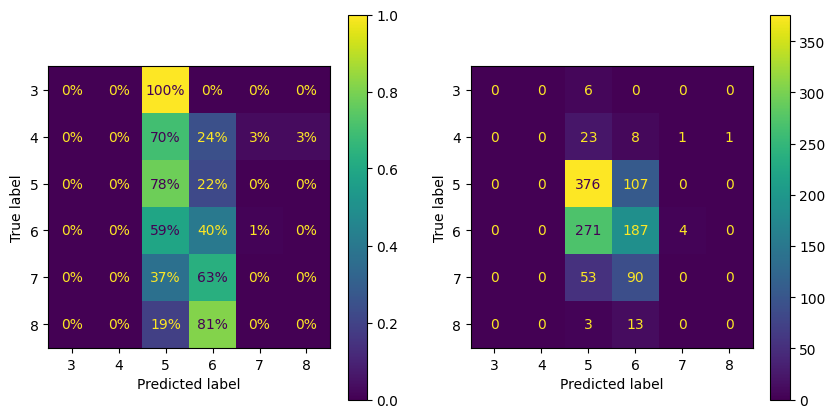

In [45]:
# 늘했던대로 kfold 방식을 채택하기 위해
predict=skmod.cross_val_predict(estimator=ovr_svc,X=wine[feature],y=wine[target],cv=3,n_jobs=3)
_,a=plt.subplots(1,2,figsize=(10,5))
skmet.ConfusionMatrixDisplay.from_predictions(y_true=wine[target],y_pred=predict,normalize='true',ax=a[0],values_format=".0%")
skmet.ConfusionMatrixDisplay.from_predictions(y_true=wine[target],y_pred=predict,ax=a[1])
plt.show()
plt.close()

위와 같이 어떤 분류가 잘못되었는지 알수있다

### step 3. 다중 레이블 분류

하나의 샘플이 꼭 하나의 클래스에만 해당하리라는 보장이 없다.

예를 들어 학생의 label은 학년/반 으로 나눠어져있듯 여러개의 label을 가질 수 있기 때문

In [46]:
# 간단한 label을 만들어보자
high_quality=(wine[target]<=4)
multi_target=np.c_[wine[target],high_quality]

In [47]:
multi_target

array([[5, 0],
       [5, 0],
       [5, 0],
       ...,
       [5, 0],
       [6, 0],
       [5, 0]], dtype=int64)

In [48]:
# 위의 모델을 다시 사용해보자 ; 지원가능성을 확인해봐야한다
import sklearn.multioutput as skmulti

In [49]:
multi_scv=skmulti.MultiOutputClassifier(estimator=sksvm.SVC(random_state=10))

In [50]:
multi_scv.fit(X=wine[feature],Y=multi_target)

MultiOutputClassifier(estimator=SVC(random_state=10))

### Step 4. 평가

In [52]:
predict=skmod.cross_val_predict(multi_scv,X=wine[feature],y=multi_target,cv=3)

In [58]:
skmet.f1_score(y_pred=predict[:,1],y_true=multi_target[:,1],average="macro")

0.49132176234979974

위와 같이 평가해야하는데 성능지표는 모델 학습과 함께 부가적으로 더 알아보자